In [1]:
import torch
import torch.optim as optim
import torch.utils.data
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import statistics

In [2]:
#--- hyperparameters ---
N_EPOCHS = 200
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 64
BATCH_SIZE_VALIDATION = 64
LR = 0.01

In [3]:
#--- fixed constants ---
NUM_CLASSES = 24
DATA_DIR = '../data/sign_mnist_%s'

In [4]:
# --- Dataset initialization ---

# We transform image files' contents to tensors
# Plus, we can add random transformations to the training data if we like
# Think on what kind of transformations may be meaningful for this data.
# Eg., horizontal-flip is definitely a bad idea for sign language data.
# You can use another transformation here if you find a better one.
train_transform = transforms.Compose([
                                        #.Grayscale(),
                                        transforms.RandomRotation(15),
                                        transforms.ToTensor(),
                                    ])
test_transform = transforms.Compose([
                                        #transforms.Grayscale(),
                                        transforms.RandomRotation(15),
                                        transforms.ToTensor(),


])

train_set = datasets.ImageFolder(DATA_DIR % 'train', transform=train_transform)
dev_set   = datasets.ImageFolder(DATA_DIR % 'dev',   transform=test_transform)
test_set  = datasets.ImageFolder(DATA_DIR % 'test',  transform=test_transform)

# Create Pytorch data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=dev_set, batch_size=BATCH_SIZE_VALIDATION, shuffle=True)

In [5]:
#--- model ---
class CNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3),
            nn.MaxPool2d(2,2),
            nn.Tanh(),
            nn.Conv2d(12, 48, kernel_size=3),
            nn.MaxPool2d(2,2),
            nn.Tanh(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(1200, 2048),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(2048, 128),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(128, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        #print(x.shape)
        x = x.view(-1, x.shape[1:].numel())
        #print(x.shape)
        x = self.fc_layers(x)
        return x

In [6]:
#--- set up ---
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.75)
loss_function = F.nll_loss

Validation: Epoch 0: Loss: 171.4890 | Validation Acc: 9.343% (327/3500)
Validation: Epoch 1: Loss: 111.1013 | Validation Acc: 34.143% (1195/3500)
Validation: Epoch 2: Loss: 65.4097 | Validation Acc: 59.714% (2090/3500)
Validation: Epoch 3: Loss: 48.6205 | Validation Acc: 69.629% (2437/3500)
Validation: Epoch 4: Loss: 32.7271 | Validation Acc: 80.857% (2830/3500)
Validation: Epoch 5: Loss: 25.0212 | Validation Acc: 84.686% (2964/3500)
Validation: Epoch 6: Loss: 21.5694 | Validation Acc: 87.686% (3069/3500)
Validation: Epoch 7: Loss: 20.8798 | Validation Acc: 87.886% (3076/3500)
Validation: Epoch 8: Loss: 19.3117 | Validation Acc: 88.657% (3103/3500)
Validation: Epoch 9: Loss: 17.0342 | Validation Acc: 90.629% (3172/3500)
Validation: Epoch 10: Loss: 17.5458 | Validation Acc: 89.971% (3149/3500)
Validation: Epoch 11: Loss: 16.5083 | Validation Acc: 90.686% (3174/3500)
Validation: Epoch 12: Loss: 16.5824 | Validation Acc: 90.857% (3180/3500)
Validation: Epoch 13: Loss: 15.4036 | Validation

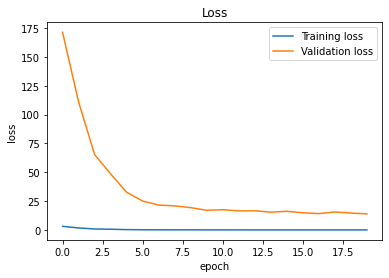

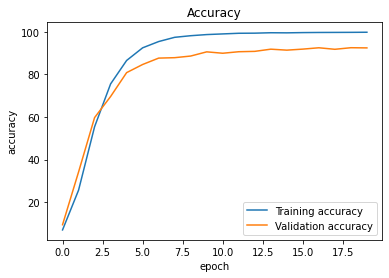

In [7]:
training_losses = []
validation_losses = []

training_accuracies = []
validation_accuracies = []


epoch_stopped = 0

#--- training ---
for epoch in range(N_EPOCHS):
    train_loss = 0
    train_correct = 0
    total = 0
    for batch_num, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad() 
        output = model(data)
        train_loss = loss_function(output, target)
        train_loss.backward()
        optimizer.step()
        
        pred = output.max(1, keepdim=True)[1]
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        total += data.shape[0]

        #if batch_num % 25 == 0:
        #    print('Training: Epoch %d - Batch %d/%d: Loss: %.4f | Train Acc: %.3f%% (%d/%d)' % 
        #          (epoch, batch_num, len(train_loader), train_loss / (batch_num + 1), 
        #           100. * train_correct / total, train_correct, total))
    
    validation_loss = 0
    validation_correct = 0
    validation_total = 0
    
    with torch.no_grad():
        for batch_num, (data, target) in enumerate(validation_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            validation_loss += loss_function(output, target).item()
            
            pred = output.max(1, keepdim=True)[1]
            validation_correct += pred.eq(target.view_as(pred)).sum().item()
            validation_total += data.shape[0]

    
    print('Validation: Epoch %d: Loss: %.4f | Validation Acc: %.3f%% (%d/%d)' % 
          (epoch, validation_loss, (100. * validation_correct / validation_total), validation_correct, 
           validation_total))
    
    # Check if average of the last 5 validation losses is smaller than current validation loss
    if epoch > 5 and statistics.mean(validation_losses[-6:]) < validation_loss:
        epoch_stopped = epoch
        break
        
    training_losses.append(train_loss.detach().cpu())
    validation_losses.append(validation_loss)
        
    training_accuracies.append((100. * train_correct / total))
    validation_accuracies.append((100. * validation_correct / validation_total))

    
plt.plot(range(epoch_stopped), training_losses, label = "Training loss")
plt.plot(range(epoch_stopped), validation_losses, label = "Validation loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(range(epoch_stopped), training_accuracies, label = "Training accuracy")
plt.plot(range(epoch_stopped), validation_accuracies, label = "Validation accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [9]:
#--- test ---
test_loss = 0
test_correct = 0
total = 0

with torch.no_grad():
    for batch_num, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        test_loss += loss_function(output, target).item()
        pred = output.max(1, keepdim=True)[1]
        test_correct += pred.eq(target.view_as(pred)).sum().item()
        total += data.shape[0]

        test_loss /= len(test_loader.dataset)
        
        if batch_num % 25 == 0:

            print('Evaluating: Batch %d/%d: Loss: %.4f | Test Acc: %.3f%% (%d/%d)' % 
                  (batch_num, len(test_loader), test_loss / (batch_num + 1), 
                   100. * test_correct / total, test_correct, total))

print("Final test score: Loss: %.4f, Accuracy: %.3f%%" % (test_loss, (100. * test_correct / total)))

Evaluating: Batch 0/58: Loss: 0.0000 | Test Acc: 96.875% (62/64)
Evaluating: Batch 25/58: Loss: 0.0000 | Test Acc: 93.029% (1548/1664)
Evaluating: Batch 50/58: Loss: 0.0000 | Test Acc: 92.525% (3020/3264)
Final test score: Loss: 0.0000, Accuracy: 92.375%
